In [1]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
## Load data for future cells

import numpy as np
import pandas as pd
import csv
import random
import uuid

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

df = pd.read_csv("nyc-rolling-sales.csv")

#filter out rows
#BOROUGH:
#Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5)
#singleFamilyHomes = ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "C9"] #no need, just RESIDENTIAL UNITS == 1

    
## filter rows
# remove null strings
df = df[df["YEAR BUILT"] != 0]
df = df[df["ZIP CODE"] != 0]
df = df[df["SALE PRICE"] != ' -  ']
df = df[df["LAND SQUARE FEET"] != ' -  ']
df = df[df["GROSS SQUARE FEET"] != ' -  ']
# convert to numeric
df["BOROUGH"] = df["BOROUGH"].apply(np.int64)
df["SALE PRICE"] = pd.to_numeric(df["SALE PRICE"])
df["LAND SQUARE FEET"] = pd.to_numeric(df["LAND SQUARE FEET"])
df["GROSS SQUARE FEET"] = pd.to_numeric(df["GROSS SQUARE FEET"])
df = df[df["LAND SQUARE FEET"] != 0]
df = df[df["GROSS SQUARE FEET"] != 0]

#only get estates with 1 residential unit (single family homes)
df = df[df["RESIDENTIAL UNITS"] == 1]

# remove estates that cost less than 10k, as they could be in-family
# transfers or errant rows
df = df[df["SALE PRICE"] > 10000]

#link boroughs to zipcodes:
# borough-zipcode data linkage:
# -drop all non-unique zipcode rows from the dataframe
# then do the following:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# df[["BOROUGH", "ZIP CODE"]]
borough1_zipcodes = [10011,10013,10012,10003,10014,10030,10031,10029,10463,10017,10022,10036,10016,10065,10021,10075,10028,10128,10023,10024,10025]
borough2_zipcodes = [10457,10458,10469,10466,10475,10468,10467,10473,10472,10464,10803,10465,10460,10471,10453,10452,10474,10451,10456,10462,10461,10455,10459,10454,10470]
borough3_zipcodes = [11228,11214,11220,11209,11221,11233,11213,11206,11216,11205,11238,11204,11219,11234,11217,11201,11218,11235,11212,11237,11207,11236,11239,11231,11224,11225,11208,11226,11210,11230,11203,11229,11215,11223,11222,11211,11232,11249]
borough4_zipcodes = [11370,11691,11692,11106,11103,11377,11105,11102,11361,11360,11357,11358,11364,11694,11426,11428,11004,11001,11435,11693,11411,11356,11354,11368,11363,11362,11369,11373, 11378, 11040, 11355, 11365, 11367, 11366, 11375, 11374, 11385, 11421, 11432, 11423, 11412, 11427, 11429, 11414, 11372, 11433, 11422, 11418, 11415, 11413, 11101, 11379, 11416, 11417, 11420, 11419, 11436, 11434, 11104]
borough5_zipcodes = [10312,10305,10314,10303,10310,10302,10301,10304,10306,10308,10309,10307]
borough_list = [borough1_zipcodes,borough2_zipcodes,borough3_zipcodes,borough4_zipcodes,borough5_zipcodes]

#convert date
df["SALE DATE"] = pd.to_datetime(df["SALE DATE"])
df['SALE MONTH'] = pd.DatetimeIndex(df['SALE DATE']).month

## select columns
df = df[['BUILDING CLASS AT TIME OF SALE','RESIDENTIAL UNITS','SALE DATE',
         'BOROUGH','ZIP CODE','YEAR BUILT','SALE MONTH','LAND SQUARE FEET','GROSS SQUARE FEET','SALE PRICE']]

## rescale indexes to new size
df.index = range(0, len(df))

# Descriptive Method
The descriptive method is being computed. This section might take 1 minute to display images.

### Visualize Descriptive Clusters
Visualize the clustering results of our data using scatter plots

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12683 samples in 0.022s...
[t-SNE] Computed neighbors for 12683 samples in 0.212s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12683
[t-SNE] Computed conditional probabilities for sample 2000 / 12683
[t-SNE] Computed conditional probabilities for sample 3000 / 12683
[t-SNE] Computed conditional probabilities for sample 4000 / 12683
[t-SNE] Computed conditional probabilities for sample 5000 / 12683
[t-SNE] Computed conditional probabilities for sample 6000 / 12683
[t-SNE] Computed conditional probabilities for sample 7000 / 12683
[t-SNE] Computed conditional probabilities for sample 8000 / 12683
[t-SNE] Computed conditional probabilities for sample 9000 / 12683
[t-SNE] Computed conditional probabilities for sample 10000 / 12683
[t-SNE] Computed conditional probabilities for sample 11000 / 12683
[t-SNE] Computed conditional probabilities for sample 12000 / 12683
[t-SNE] Computed conditional probabilities for sam

No handles with labels found to put in legend.


[t-SNE] KL divergence after 1000 iterations: 0.498588


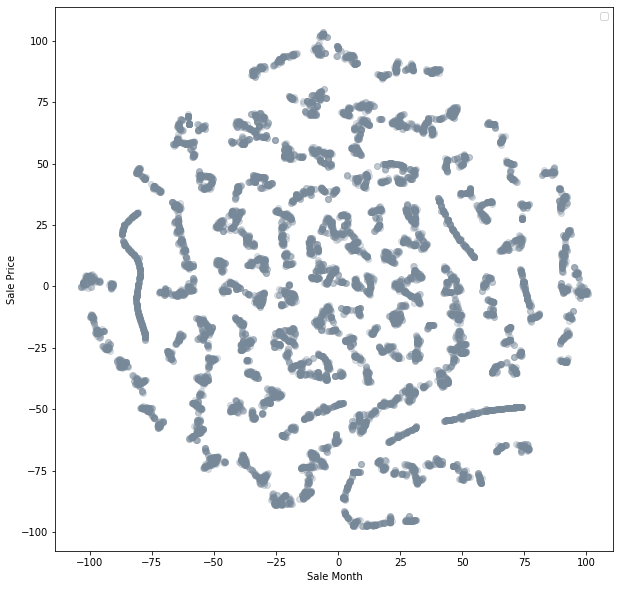

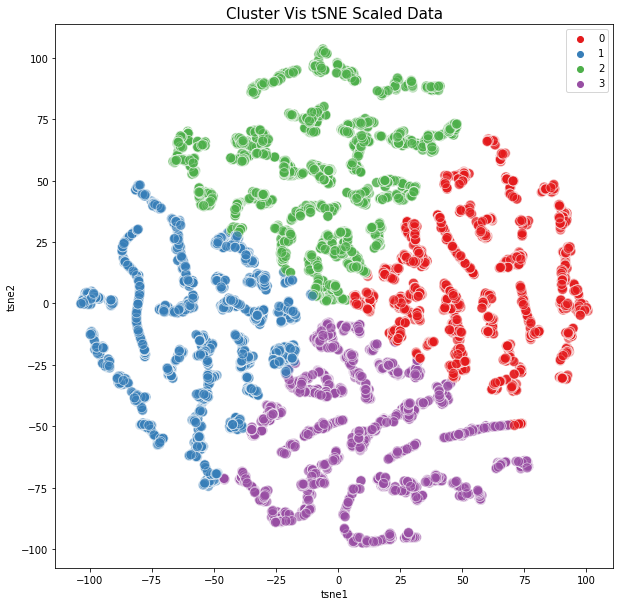

In [4]:
## Compute t-sne clusters for the descriptive method
# takes one minute for this cell to finish running
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=200)
tsne_scale_results = tsne.fit_transform(df.iloc[:, 3:10])

tsne_df_scale = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2'])

plt.figure(figsize = (10,10))
plt.scatter(tsne_scale_results[:,0],tsne_scale_results[:,1],alpha=0.25, facecolor='lightslategray')
plt.xlabel('Sale Month')
plt.ylabel('Sale Price')
plt.legend()
plt.show()

## calculate k-means clusters from
from sklearn.cluster import KMeans
import seaborn as sns

# apply kmeans to t-sne clusters.
sse = []
k_list = range(1, 15)

for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(tsne_df_scale)
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})

plt.figure(figsize = (10,10))

kmeans_tsne_scale = KMeans(n_clusters=4, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df_scale)
labels_tsne_scale = kmeans_tsne_scale.labels_

clusters_tsne_scale = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)
sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1],hue=labels_tsne_scale, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE Scaled Data', fontsize=15)
plt.legend()
plt.show()

Visualize a grid of the seperate properties of each of our 4 distinct k-means clusters using histograms

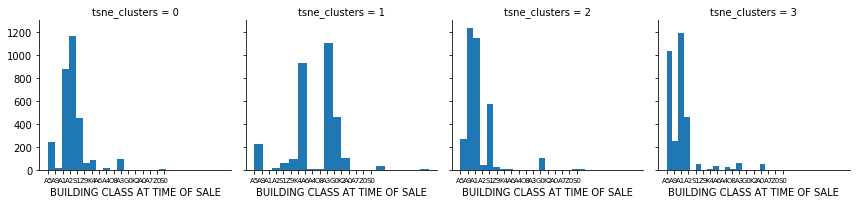

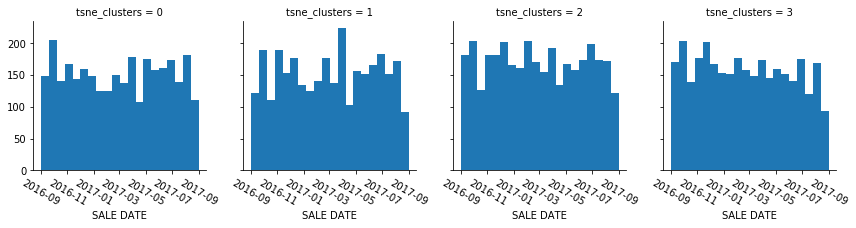

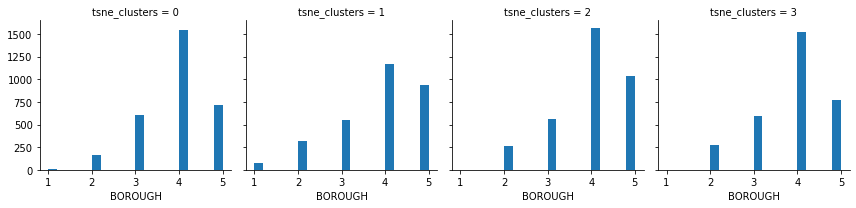

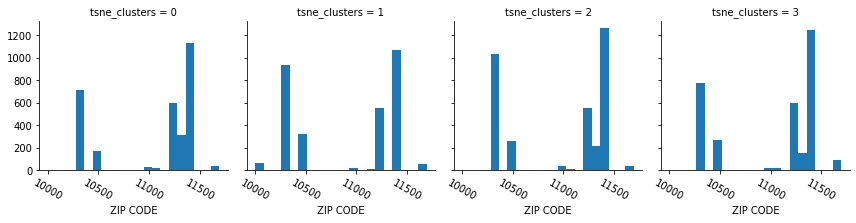

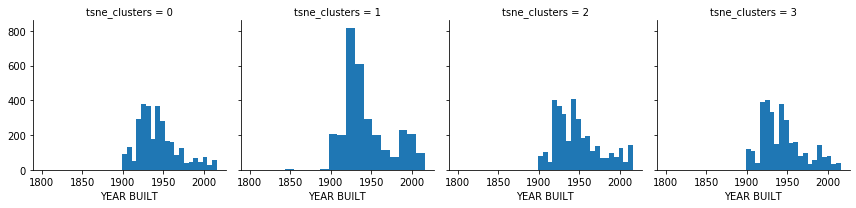

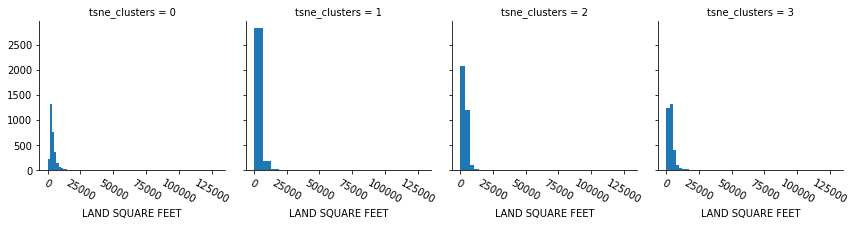

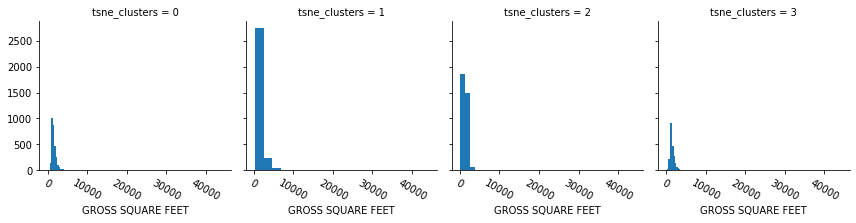

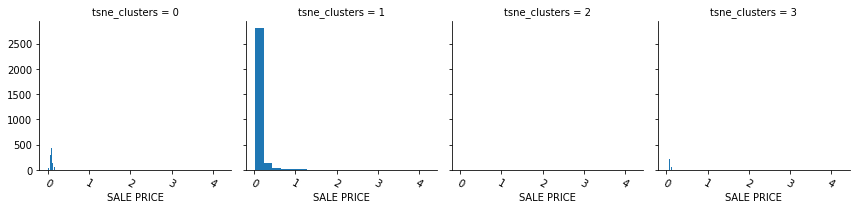

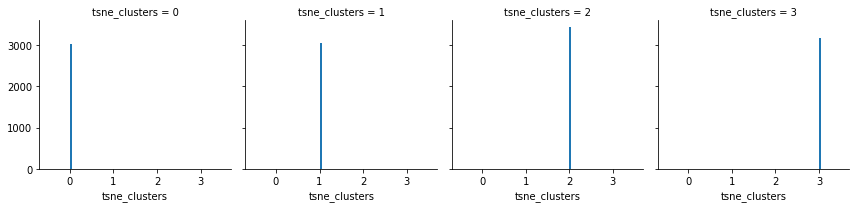

In [11]:
import math
import seaborn as sns

cluster_tsne_profile = pd.merge(df, clusters_tsne_scale['tsne_clusters'], left_index=True, right_index=True)

from functools import partial
bin_hist = partial(plt.hist,bins=20)
bin_hist.__name__ = "bin_hist"
bin_hist.__module__ = plt.hist.__module__

for c in cluster_tsne_profile:
    
    # sale month is for regression only, we use sale date instead
    if(c == "SALE MONTH" or c == "RESIDENTIAL UNITS"):
        continue

    grid = sns.FacetGrid(cluster_tsne_profile, col='tsne_clusters')
    grid.map(bin_hist, c)
    
    if(c == "SALE PRICE"):
        #grid.ticklabel_format(style='plain', axis='x')
        grid.set_xticklabels(rotation=-30,style='normal')
    
    if(c == "SALE DATE" or c == "ZIP CODE" or c == "LAND SQUARE FEET" or c == "GROSS SQUARE FEET"):
        grid.set_xticklabels(rotation=-30)
        
    if(c == "BUILDING CLASS AT TIME OF SALE"):
        grid.set_xticklabels(fontsize=7)
    
    

Visualize the multi-variable graph using scatter plots

Text(0.5, 1.0, '(tSNE) Clusters by Gross Square Feet and Price')

<Figure size 360x720 with 0 Axes>

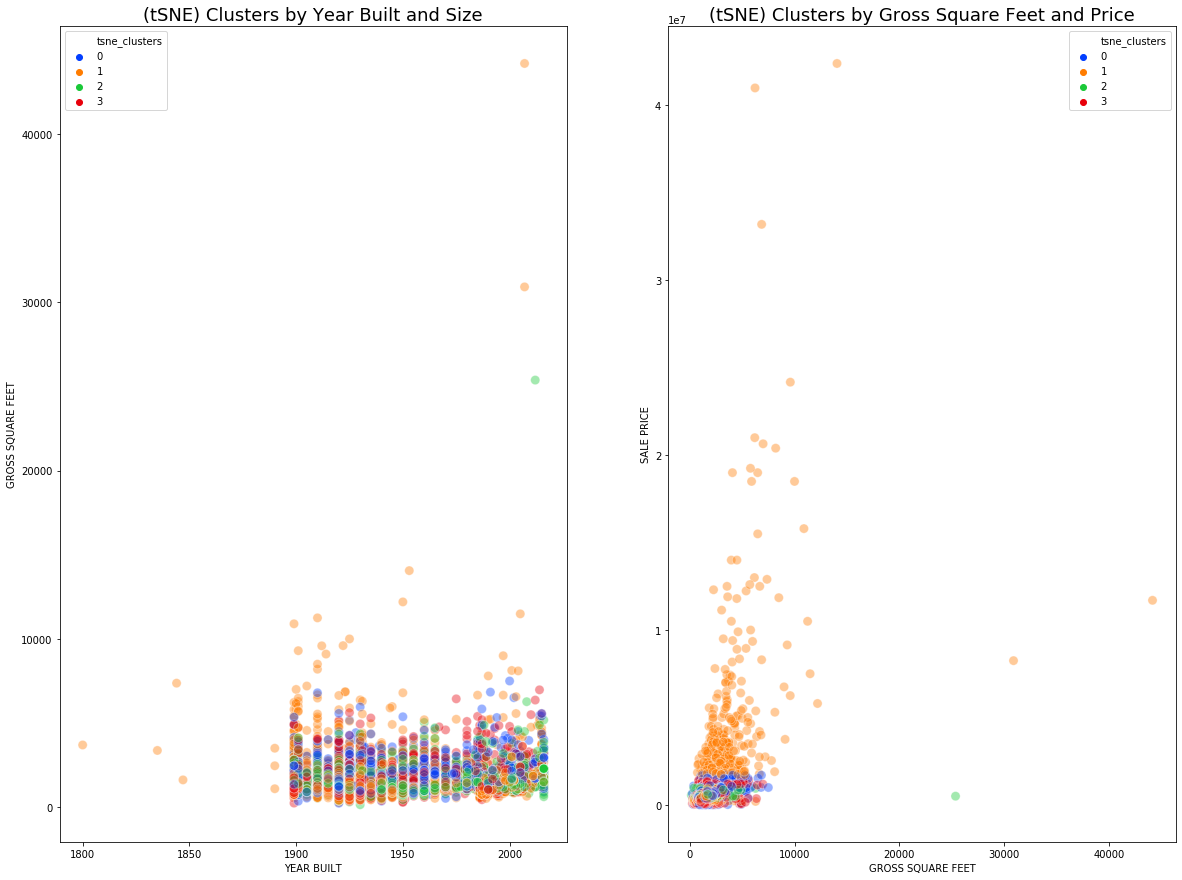

In [6]:

plt.figure(figsize=(5,10))
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,15))

# left graph
sns.scatterplot(data=cluster_tsne_profile, x='YEAR BUILT', y='GROSS SQUARE FEET', hue='tsne_clusters', s=85, alpha=0.4, palette='bright', ax=ax1).set_title('(tSNE) Clusters by Year Built and Size', fontsize=18)

# right graph.
sns.scatterplot(data=cluster_tsne_profile, x='GROSS SQUARE FEET', y='SALE PRICE', hue='tsne_clusters', s=85, alpha=0.4, palette='bright', ax=ax2).set_title('(tSNE) Clusters by Gross Square Feet and Price', fontsize=18)


# Predictive Method
### Method accuracy report:

In [7]:
## Predictive method using deep forest regression
#train the deep forest model

X = df.iloc[:, 3:9].values
y = df.iloc[:, 9].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=1000, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#evaluate the model
from sklearn import metrics

print('R2:', metrics.r2_score(y_test, y_pred)) #coefficient of determination
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Max Error:', metrics.max_error(y_test, y_pred))

R2: 0.46003940688969813
Mean Absolute Error: 182013.87350262763
Mean Squared Error: 599892130725.1577
Root Mean Squared Error: 774527.03679417
Max Error: 26417341.821000002


### Predictive Method GUI
Use a deep forest model to predict how much a single-family house would cost depending on the location, month of sale, and unit specifications.

In [8]:
# UI
import ipywidgets as widgets

wide_layout=widgets.Layout(width='40%', height='30px')
med_layout=widgets.Layout(width='32%', height='30px')
label_layout={'description_width': 'initial'}
## Month slider
user_month = widgets.SelectionSlider(
    options=[('January', 1),
             ('February', 2),
             ('March', 3),
             ('April', 4),
             ("May", 5),
             ("June", 6),
             ("July", 7),
             ("August", 8),
             ("September", 9),
             ("October", 10),
             ("November", 11),
             ("December",12)],
    value=9,
    description='Month bought in 2016/2017:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    style=label_layout,
    layout=wide_layout
)

display(user_month)

##
user_yearbuilt = widgets.IntSlider(
    value=1950,
    min=1899,
    max=2016,
    step=1,
    description='Year house was built:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=label_layout,
    layout=wide_layout
)
display(user_yearbuilt)

## Borough/zip code dropdown
borough_zipcode_array = []
for line in borough1_zipcodes:
    #output example: ("Manhattan - zipcode", zipcode)
    borough_zipcode_array.append(
        tuple(("Manhattan - " + str(line), str(line)))
    )
for line in borough2_zipcodes:
    borough_zipcode_array.append(
        tuple(("Bronx - " + str(line), str(line)))
    )
for line in borough3_zipcodes:
    borough_zipcode_array.append(
        tuple(("Brooklyn - " + str(line), str(line)))
    )
for line in borough4_zipcodes:
    borough_zipcode_array.append(
        tuple(("Queens - " + str(line), str(line)))
    )
for line in borough5_zipcodes:
    borough_zipcode_array.append(
        tuple(("Staten Island - " + str(line), str(line)))
    )

user_borough = 1
user_zipcode = widgets.Dropdown(
    options=borough_zipcode_array,#[('Manhattan', 1), ('Bronx', 2), ('Brooklyn', 3), ('Queens', 4), ('Staten Island', 5)],

    description='Location:',
    style=label_layout,
    layout=med_layout
)
display(user_zipcode)


## size
user_land_sqrft= widgets.BoundedIntText(
    value=1975,
    min=0,
    max=10000,
    step=1,
    description='Land sq.ft.',
    disabled=False,
    style=label_layout,
    layout=med_layout
)
display(user_land_sqrft)
user_gross_sqrft = widgets.BoundedIntText(
    value=3855,
    min=0,
    max=10000,
    step=1,
    description='Gross sq.ft.',
    disabled=False,
    style=label_layout,
    layout=med_layout
)
display(user_gross_sqrft)

## Output text
final_output = widgets.HTML(value = f'<p style="font-size:2em">Click "Generate report" to get an estimate for a residence price.</p>')

display(final_output)
## Generate button
gen_button = widgets.Button(
    description='Generate report',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='' # (FontAwesome names without the `fa-` prefix)
)
gen_output = widgets.Output()

display(gen_button, gen_output)


def on_button_clicked(b):
                
    with gen_output:
        
        # get borough id from zipcode
        for index, b in enumerate(borough_list):
            if(int(user_zipcode.value) in b):
                user_borough = index + 1
        
        #predict new result
        sample = np.array([user_borough,
                           user_zipcode.value,
                           user_yearbuilt.value,
                           user_month.value,
                           user_land_sqrft.value,
                           user_gross_sqrft.value]).reshape(1, -1)
        y_pred = regressor.predict(sample)
        
        
        final_output.value = "<p style='font-size:2em'>Projected residence price: <font color='green'>$" + f"{int(y_pred):,d}</b></p>"
        print("Projected residance price: $" + f"{int(y_pred):,d}")
        

gen_button.on_click(on_button_clicked)

SelectionSlider(continuous_update=False, description='Month bought in 2016/2017:', index=8, layout=Layout(heig…

IntSlider(value=1950, continuous_update=False, description='Year house was built:', layout=Layout(height='30px…

Dropdown(description='Location:', layout=Layout(height='30px', width='32%'), options=(('Manhattan - 10011', '1…

BoundedIntText(value=1975, description='Land sq.ft.', layout=Layout(height='30px', width='32%'), max=10000, st…

BoundedIntText(value=3855, description='Gross sq.ft.', layout=Layout(height='30px', width='32%'), max=10000, s…

HTML(value='<p style="font-size:2em">Click "Generate report" to get an estimate for a residence price.</p>')

Button(button_style='success', description='Generate report', style=ButtonStyle(), tooltip='Click me')

Output()

### Comparision of actual values in the dataset and predicted values using our model
Given the same input parameters (location, month of sale, characteristics of housing unit), what is the actual price of the house and what does our model predict the price to be?

In [9]:
pd.DataFrame({'Actual Value':y_test.reshape(-1), 'Predicted Value':y_pred.reshape(-1)}).head(n=20).style.format("{:,.0f}")

,Actual Value,Predicted Value
0,"297,500","494,263"
1,"1,458,800","1,095,565"
2,"5,091,250","3,895,252"
3,"320,000","353,606"
4,"600,000","601,710"
5,"415,000","374,468"
6,"500,000","365,368"
7,"999,999","1,023,600"
8,"855,000","830,509"
9,"1,100,000","865,423"


### Visualize the regression model
See an example of the effect of some input parameters (location, month of sale, characteristics of housing unit) on the predicted house price using a regression scatter plot.

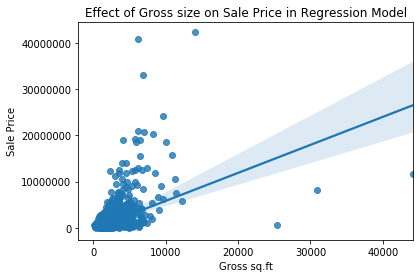

In [10]:
from matplotlib.ticker import FuncFormatter
import seaborn as sns
# visualizing regression model
sns.regplot(x="GROSS SQUARE FEET", y="SALE PRICE", data=df);

plt.title('Effect of Gross size on Sale Price in Regression Model')
plt.xlabel('Gross sq.ft')
plt.ylabel('Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()